In [84]:
#Import packages
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.optimize import minimize


In [85]:
# Read CSV files
accounting_data = pd.read_csv('DataLab3accounting.csv')
price_data = pd.read_csv('DataLab3prices.csv')
risk_free = pd.read_csv('DataLab3rf.csv')
# data is of different frequency so I keep it in seperate dataframes
print(accounting_data)


    CUSIP     LCT     DLTT    CSHO  fyear
0  307108  34.337  140.335  22.814   2015


In [86]:
print(price_data)

     Cusip      Date  Prices
0    30710  20150102  30.210
1    30710  20150105  29.730
2    30710  20150106  29.380
3    30710  20150107  28.640
4    30710  20150108  29.370
..     ...       ...     ...
247  30710  20151224  28.845
248  30710  20151228  28.110
249  30710  20151229  27.900
250  30710  20151230  27.825
251  30710  20151231  28.590

[252 rows x 3 columns]


In [87]:
print(risk_free)


      Date  Riskfree
0   201501      0.00
1   201502      0.00
2   201503      0.00
3   201504      0.00
4   201505      0.00
5   201506      0.00
6   201507      0.00
7   201508      0.00
8   201509      0.00
9   201510      0.00
10  201511      0.00
11  201512      0.01


In [88]:
def my_merton(x,sige,E,d,rf,t):
     d1 = (np.log(x[1]/d)+(rf+0.5*x[0]**2)*t)/(x[0]*np.sqrt(t))
     d2 = d1-x[0]*np.sqrt(t)
     f1 = x[1]*norm.cdf(d1)-np.exp(-rf*t)*d*norm.cdf(d2)-E # This is the equation on slide 21 Video L13 
     f2 = (x[1]/E)*norm.cdf(d1)*x[0]-sige # This is the equation on slide 22 Video L13 
     return np.sqrt(f1**2+f2**2) # Minimize f over x(1) and x(2) solves for Equity vol and Asset value


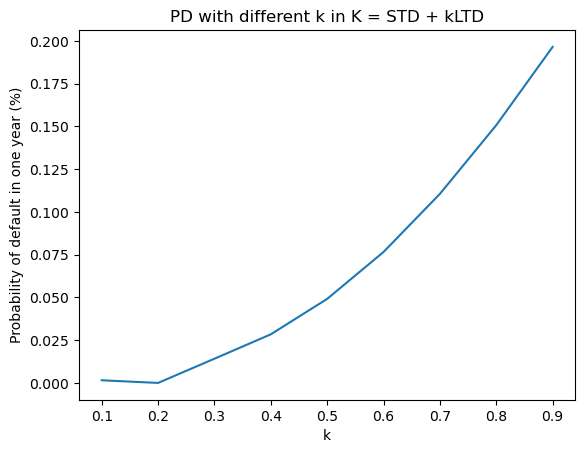

In [89]:
#Long and short term debt

x_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y_values = []
for k in x_values:

    equityReturns = np.log(price_data.Prices/price_data.Prices.shift(1))
    equityReturns = equityReturns[1:-1] # Removing the nan created by calculating returns
    sige = stats.tstd(equityReturns)*np.sqrt(250) # Standard deviation of equity (returns) scaled to yearly
    K = accounting_data.LCT+k*accounting_data.DLTT # We use 10% of long term debt which was found best in Afik et al. (2016)
    E = accounting_data.CSHO*price_data.Prices.iloc[-1] # Equity in MUSD as Number of shares * last share price
    rf = np.mean(risk_free.Riskfree) # Risk free rate as average of monthly rates
    t = 1 # We want PD in 1 year
    x0=(sige,K[0]+E[0]) # Initial quess for asset volatility and asset value,
                        # easier and faster for numerical optimization if guess is good
    x0bad = (sige,400)


    res = minimize(my_merton, x0bad, method='BFGS',
                args=(sige,E[0],K[0],rf,t), options={'disp': False})
    DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t)) # DD slide 9 VL 13
    PD = float(norm.cdf(-DD))

    y_values.append(PD*100)

    

plt.plot(x_values, y_values)
# Adding labels and legend
plt.xlabel('k')
plt.ylabel('Probability of default in one year (%)')
plt.title('PD with different k in K = STD + kLTD')


# Display the plot
plt.show()    




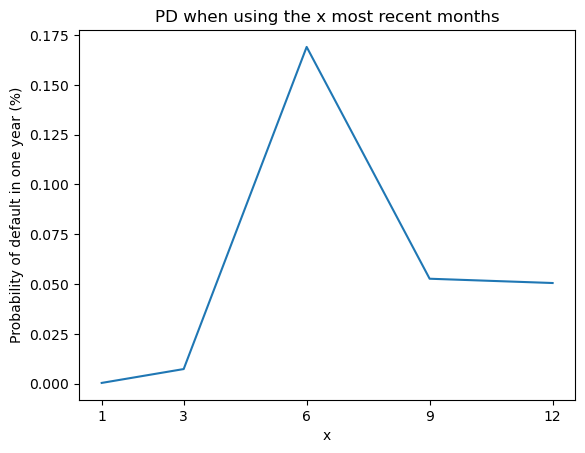

In [90]:
#Note I used all the months when estimating the risk free rate and k = 0.5. 
#That was how I interpreted the instructions but I'm a bit unsure if that's what you actually meant. 
#I tested using different rf and it didn't seem to have a large effect anyway.

#Estimating volatility using x most recent months
x_values = [1, 3, 6, 9, 12]
idx_months = [230, 188, 124, 61, 0] #idx for latest x months
y_values = []

for i in range(len(x_values)):

    #change price data to x most recent months using the indexes (i found them manually maybe there's a smarter way to do it)
    price_data_trunc = price_data[idx_months[i]:251] #latest months
    equityReturns = np.log(price_data_trunc.Prices/price_data_trunc.Prices.shift(1))
    equityReturns = equityReturns[1:-1] # Removing the nan created by calculating returns

    #this is something that confuses me a bit actually, i'm thinking that we should scale the std to yearly for this to work even though our sample is of a different size
    sige = stats.tstd(equityReturns)*np.sqrt(250) # Standard deviation of equity (returns) scaled to yearly
    
   
    rf = np.mean(risk_free.Riskfree) # Risk free rate as average of x last monthly rates
    K = accounting_data.LCT+0.5*accounting_data.DLTT # We use 50% of long term debt 

    #same as before below 
    E = accounting_data.CSHO*price_data.Prices.iloc[-1] # Equity in MUSD as Number of shares * last share price
    t = 1 # We want PD in 1 year

    x0=(sige,K[0]+E[0]) # Initial quess for asset volatility and asset value,
                        # easier and faster for numerical optimization if guess is good
    x0bad = (sige,400)


    res = minimize(my_merton, x0bad, method='BFGS',
                args=(sige,E[0],K[0],rf,t), options={'disp': False})
    DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t)) # DD slide 9 VL 13
    PD = float(norm.cdf(-DD))

    y_values.append(PD*100)

    

plt.plot(x_values, y_values)
# Adding labels and legend
plt.xlabel('x')
plt.ylabel('Probability of default in one year (%)')
plt.title('PD when using the x most recent months')

new_xticks = x_values  # New tick labels
plt.xticks(x_values, new_xticks)  # Set new tick labels for each original x-value


# Display the plot
plt.show()    



In [91]:
#Estimating vol using EWMA model

equityReturns = np.log(price_data.Prices/price_data.Prices.shift(1))
equityReturns = equityReturns[1:-1] # Removing the nan created by calculating returns


#Time varying volatility
T = 250

eta = equityReturns.tolist() # Setting innovation equal to returns is ok since daily returns close to zero and hard to predict
sigma = [np.var(eta)] # Sigma_0 in slides
lambda_par = 0.94 # RiskMetrics



for j in range(1,T+1): 
    sigma.append((1-lambda_par)*eta[j-1]**2+lambda_par*sigma[j-1])

sigma = np.array(sigma)
annualized_percent_vol = (250*sigma)**0.5
    
sige = np.mean(annualized_percent_vol) # Standard deviation of equity (returns) scaled to yearly
    
    
K = accounting_data.LCT+0.5*accounting_data.DLTT # We use 50% of long term debt
E = accounting_data.CSHO*price_data.Prices.iloc[-1] # Equity in MUSD as Number of shares * last share price
rf = np.mean(risk_free.Riskfree) # Risk free rate as average of monthly rates
    
    
t = 1 # We want PD in 1 year


x0=(sige,K[0]+E[0]) # Initial quess for asset volatility and asset value,
                        # easier and faster for numerical optimization if guess is good
x0bad = (sige,400)


res = minimize(my_merton, x0bad, method='BFGS',
                args=(sige,E[0],K[0],rf,t), options={'disp': False})
DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t)) # DD slide 9 VL 13
PD = float(norm.cdf(-DD))

print("Probability of default within one year is {:.5f} %".format(PD*100))

Probability of default within one year is 0.03799 %


a: Which input is the Merton model most senstitive to?

It seems to be both sensitive to the number of months used and the k used to estimate K = LTD + k*STD. It did not seem to be very sensitive to estimating volatility using EWMA model. Overall I think it seems to be most sensitive to k, as PD varied between 0 to 0.2%, although it did so in a very predictable manner. It also varied depending of numbers of month used, peaking at 6 months at PD = 0.175%. I'd say if I had to choose one that it is most sensitive to k. 





b: Given the sensitivity, do you think the Merton model is a useful model for risk management?

Well that is a bit tough question to answer. At what point can a model to be deemed useful? The model should be judged on its predicative power. Considering how sensitive it is to how we estimate both debt and volatility it does not seem to a very good predictor me. An ideal model should give fairly consistent results regardless of how we calculate volatility and or debt.

With that said, it can still be useful. Like we went through in the lecture, we can probably standardize this model by looking at ROC curves and AOC values, just like Atik. et al. (2016) did. Using this type of standardization it can be used to compare different companies with each other and perhaps make a prediction.

So in short: I think you could come up with a better (and by that I mean less sensitive) model but the Merton model can still be useful if handled with the proper care.
